# NengoBio Examples

This notebook contains a few examples demonstrating the capabilities of *NengoBio*.

First, we'll need to do a little bit of book-keeping. Feel free to skip ahead to the first example below.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import nengo
import nengo_bio as bio
import numpy as np

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

Constants defining the plots below.

In [2]:
PROBE_SYNAPSE = 0.1 # Filter to be used for the network output
T = 10.0 # Total simulation time
T_SKIP = 1.0 # Time to exclude from the RMSE
SEED = 4891 # Network seed
SS = 100 # Plot subsample

`run_and_plot` and `plot_weights` are functions we'll be using to plot the results of a simulation run and to compare them to the desired results.

In [3]:
def run_and_plot(model, probe, expected_fns, plot=True):
    # Run the simulation for the specified time
    with nengo.Simulator(model, progress_bar=None) as sim:
        sim.run(T)

    # Fetch the time and the probe data
    ts = sim.trange()
    expected = np.array([f(ts - PROBE_SYNAPSE) for f in expected_fns]).T
    actual = sim.data[probe]

    # Compute the slice over which to compute the error
    slice_ = slice(int(T_SKIP / sim.dt), int(T / sim.dt))

    # Compute the RMSE and the RMSE
    rms = np.sqrt(np.mean(np.square(expected)))
    rmse = np.sqrt(np.mean(np.square(expected[slice_] - actual[slice_])))

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ts[::SS], expected[::SS], 'k--', label='Expected')
        ax.plot(ts[::SS], actual[::SS], label='Actual')
        ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.3))
        ax.set_title("Normalised RMSE = {:0.2f}%".format(100.0 * rmse / rms))
        ax.set_xlabel("Time $t$ (s)")
        ax.set_ylabel("Decoded value $x$")

    return sim

def plot_weights(sim, conn):
    # Fetch the weights fro the model
    weights = sim.model.params[conn].weights
    WE, WI = weights[bio.Excitatory], weights[bio.Inhibitory]

    # Count the number of empty rows/columns
    def count_zero_rows(X):
        n = 0
        for i in range(X.shape[0]):
            if np.all(X[i] == 0):
                n += 1
        return n
    n_exc_zero_rows, n_inh_zero_rows = count_zero_rows(WE), count_zero_rows(WI)

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    axs[0].imshow( WE, vmin=0, vmax=np.median(WE[WE > 0]))
    axs[0].set_xlabel('Target neuron index')
    axs[0].set_ylabel('Source neuron index')
    axs[0].set_title('Excitatory ({} rows empty)'.format(n_exc_zero_rows))

    axs[1].imshow(-WI, vmin=0, vmax=np.median(-WI[WI < 0]))
    axs[1].set_xlabel('Target neuron index')
    axs[1].set_ylabel('Source neuron index')
    axs[1].set_title('Inhibitory ({} rows empty)'.format(n_inh_zero_rows))

    axs[2].imshow(WE-WI, vmin=0, vmax=np.median((WE-WI)[(WE-WI) > 0]))
    axs[2].set_xlabel('Target neuron index')
    axs[2].set_ylabel('Source neuron index')
    axs[2].set_title('Combined weights')

    fig.tight_layout()

## Example 1: Communication Channel

### Multiple pre-ensembles

This first example demonstrates the ability of *NengoBio* to support multiple pre-objects in `bio.connection`. When passing a `tuple` (using "()" notation) to the connection object, the dimensions of the pre-objects are stacked.

Here, we're connecting two one-dimensional pre-ensembles to a two-dimensional post-ensemble.

Solved 103/103 neuron weights

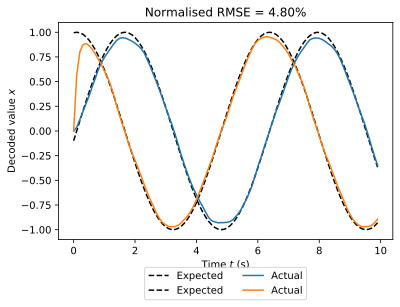

In [4]:
f1, f2 = lambda t: np.sin(t), lambda t: np.cos(t)
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(f1)
    inp_b = nengo.Node(f2)

    ens_a = bio.Ensemble(n_neurons=101, dimensions=1)
    ens_b = bio.Ensemble(n_neurons=102, dimensions=1)
    ens_c = bio.Ensemble(n_neurons=103, dimensions=2)

    nengo.Connection(inp_a, ens_a)
    nengo.Connection(inp_b, ens_b)

    bio.Connection((ens_a, ens_b), ens_c)

    probe = nengo.Probe(ens_c, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (f1, f2));

### Marking neurons as excitatory/inhibitory

The `p_exc` and `p_inh` arguments on the `bio.Ensemble` object can be used to mark a certain fraction of the neurons in the ensemble as excitatory/inhibitory.

Solved 103/103 neuron weights

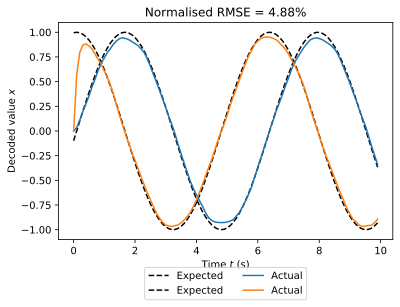

In [5]:
f1, f2 = lambda t: np.sin(t), lambda t: np.cos(t)
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(f1)
    inp_b = nengo.Node(f2)

    ens_a = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
    ens_b = bio.Ensemble(n_neurons=102, dimensions=1, p_exc=0.8)
    ens_c = bio.Ensemble(n_neurons=103, dimensions=2)

    nengo.Connection(inp_a, ens_a)
    nengo.Connection(inp_b, ens_b)

    bio.Connection((ens_a, ens_b), ens_c)

    probe = nengo.Probe(ens_c, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (f1, f2));

## Example 2: Parisien Transform (Dale's Principle with inhibitory interneurons)

### Basic circuit ‒ defining inhibitory interneurons

Inhibition in biological systems is often mediated via inhibitory interneurons. This example attempts to builds such a circuit by projecting from both the excitatory pre-population and a set of inhibitory interneurons onto the same target population.

Solved 103/103 neuron weights

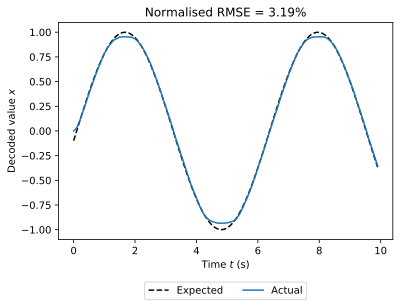

In [6]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x))

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t),));

This seems to work quite well!

### Defining evaluation points to compute functions of shared dimensions

Let's see what happens if we try to compute some function, for example $f(x) = x^2$.

Solved 103/103 neuron weights

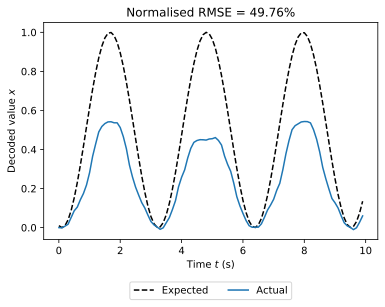

In [7]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x) ** 2)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

This doesn't look very good. The issue is that we're optimizing over a 2D space, i.e., the Cartesian product of all possible represented values of the pre-population and the interneuron population. However, the pre-population and the interneuron population should always represent the same value.

Let's see what happens when we set the evaluation points of the connection to the diagonal:

Solved 103/103 neuron weights

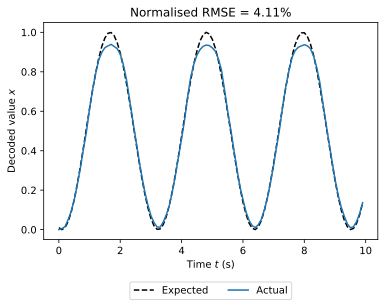

In [8]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection((ens_source, ens_inhint), ens_target,
                   function=lambda x: np.mean(x) ** 2,
                   eval_points=([1, 1] * np.linspace(-1, 1, 750)[:, None]),
                   scale_eval_points=False)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

This looks much nicer.

### The NengoBio `set` notation for shared dimensions

There is a special syntax that tells *NengoBio* that two pre-populations represent the same value. Instead of the tuple notation we use the `set` notation (i.e., "{}") to specify the pre-populations.

Solved 103/103 neuron weights

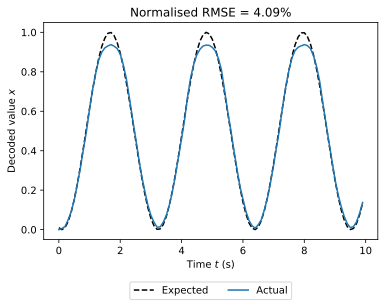

In [9]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))
    
    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

Note that the error in the second example is a little higher due to the samples not being equally distributed across the space. Specifying the evaluation points explicitly will give exactly the same results as above:

Solved 103/103 neuron weights

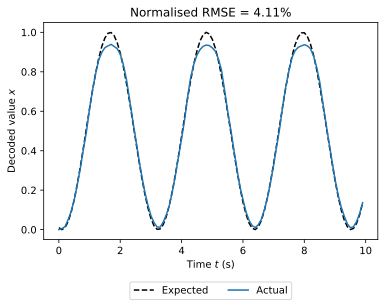

In [10]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint)
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2,
                   eval_points=np.linspace(-1, 1, 750).reshape(-1, 1),
                   scale_eval_points=False)

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

### Subthreshold relaxation

One issue with the default weight solver is that the solver treats negative post-synaptic currents the same way as positive post-synaptic currents. In other words, the solver tries to find weights that *exactly* produce negative target currents. However, and at least for most simple neuron models, all currents below a certain threshold result in a zero spike rate. Thus, the exact magnitute of these subthreshold currents does not matter.

We can *relax* the optimization problem by instructing the optimizer to focus on the relevant parts of the optimization problem. We do this by passing the `relax=True` flag to the solver.

**Note:** Setting `relax=True` significantly increases the time it takes to solve for weights. This is because the relaxed optimization problem can no longer  be expressed as a NNLS (non-negative least squares) problem, a special case of a QP (quadratic program).

Solved 103/103 neuron weights

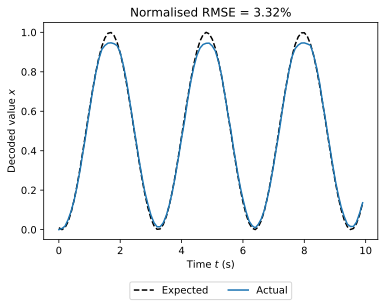

In [11]:
with nengo.Network(seed=SEED) as model:
    inp_a = nengo.Node(lambda t: np.sin(t))

    ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=1.0)
    ens_inhint = bio.Ensemble(n_neurons=102, dimensions=1, p_inh=1.0)
    ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

    nengo.Connection(inp_a, ens_source)
    bio.Connection(ens_source, ens_inhint,
                   solver=bio.solvers.QPSolver(relax=True))
    bio.Connection({ens_source, ens_inhint}, ens_target,
                   function=lambda x: x ** 2,
                   solver=bio.solvers.QPSolver(relax=True))

    probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

run_and_plot(model, probe, (lambda t: np.sin(t) ** 2,));

Well, setting `relax=True` improves the overall performance quite significantly!

## Example 3: Sparse connection matrices

Sometimes we have pretty good data about the *convergence* $n$ and *divergence* $m$ numbers of two neuron populations. These numbers are defined as follows:

* **Convergence $n$:** How many pre-neurons project onto one post-neurons ($n \longrightarrow 1$)?
* **Divergence $m$:** How many post-neurons receive input from one pre-neuron ($1 \longrightarrow m$)?

*NengoBio* allows to specifiy these numbers by putting connectivity constraints onto the `Connection` object. This can be done by setting the `connectivity` argument to one of

* **`UnconstrainedConnectivity()`**  
  Deactivates all connectivity constraints, including Dale's principle, resulting in true all-to-all connectivity.
* **`DefaultConnectivity()`**  
  Takes Dale's principle into account (this is the default).
* **`ConstrainedConnectivity(convergence=None, divergence=None, probabilities=None)`**  
  Limits the connectivity according to the given convergence and divergence numbers. If no convergence and divergence parameters are given, this is equivalent to `DefaultConnectivity`. Optionally, a function (or array) `probabilities` can be provided that contains the connection probabilities for individual neurons.
* **`SpatiallyConstrainedConnectivity(convergence=None, divergence=None, sigma=0.25, projection=None)`**  
  Computes a probability matrix based on the spatial location of the individual neurons (see below).

Before demonstrating this though, let's have a look at the default, unconstrained connection weights.

Solved 100/103 neuron weights

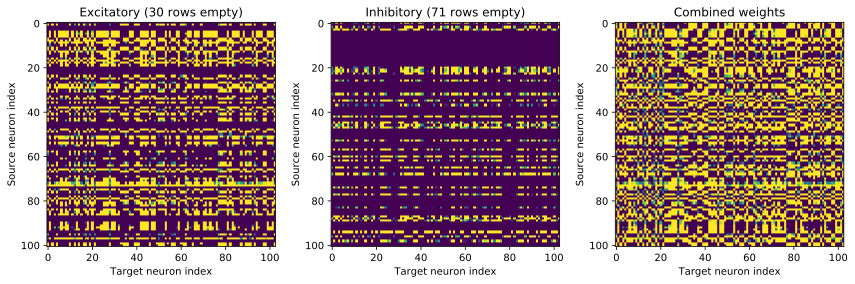

In [12]:
def connectivity_constraints_test(connectivity):
    with nengo.Network(seed=SEED) as model:
        inp_a = nengo.Node(lambda t: np.sin(t))

        ens_source = bio.Ensemble(n_neurons=101, dimensions=1, p_exc=0.8)
        ens_target = bio.Ensemble(n_neurons=103, dimensions=1)

        nengo.Connection(inp_a, ens_source)
        conn = bio.Connection(
            ens_source, ens_target,
            connectivity=connectivity
        )

        probe = nengo.Probe(ens_target, synapse=PROBE_SYNAPSE)

    sim = run_and_plot(model, probe, (lambda t: np.sin(t),), plot=False)
    plot_weights(sim, conn)

# This is the default connectivity that respects Dale's principle
connectivity_constraints_test(bio.DefaultConnectivity())

With the afforementioned attributes we can force a sparse weight matrix:

Solved 103/103 neuron weights

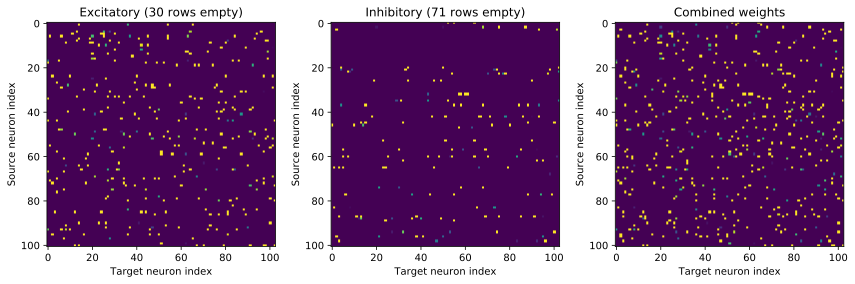

In [13]:
connectivity_constraints_test(bio.ConstrainedConnectivity(convergence=10))

`convergence=10` forces each post-neuron to receive input from *at most* 10 pre-neurons. We get a similar picture for `divergence=10`:

Solved 103/103 neuron weights

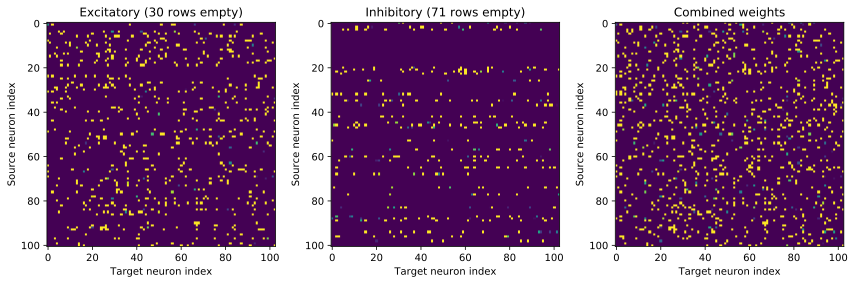

In [14]:
connectivity_constraints_test(bio.ConstrainedConnectivity(divergence=20))

Now each pre-neuron connects to *at most* 10 post-neurons. We can also set the two parameters at the same time, but be aware that the ratio of pre- to post- neurons along with the *convergence* parameter fully determines the divergence and vice versa. So if both *convergence* and *divergence* are set and the pre- to post-ratio does not match these numbers, the resulting convergence and divergence numbers will be smaller than what has been requested.

## Example 4: Sparse connection matrices with spatial connection probabilities

Sometimes we'd like to model a certain connectivity structure. For example, we might know that our neurons are arranged in a certain 2D pattern and would like to modulate the connection probabilities by their closeness.

This is exactly what the `locations` argument in the `Ensemble` class is for.

### The `NeuralSheetDist` class
The `NeuralSheetDist` class is a `nengo.Distribution` class that can be used to assign a location to each neuron in a population. In partciular, this class internally uses a Hilbert curve to ensure that neurons are at approximately equidstant locations and that neurons with similar indices are approximately close together.

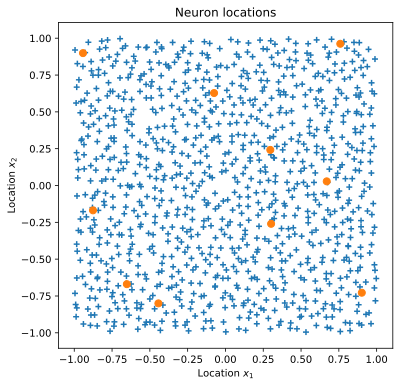

In [15]:
with nengo.Network() as model:
    ens_1 = bio.Ensemble(
        n_neurons=1000,
        dimensions=1,
        locations=bio.NeuralSheetDist())

    ens_2 = bio.Ensemble(
        n_neurons=10,
        dimensions=1,
        locations=bio.NeuralSheetDist())

with nengo.Simulator(model, progress_bar=None) as sim:
    pass

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(sim.data[ens_1].locations[:, 0], sim.data[ens_1].locations[:, 1], marker='+')
ax.scatter(sim.data[ens_2].locations[:, 0], sim.data[ens_2].locations[:, 1], marker='o', sizes=[50])
ax.set_xlabel('Location $x_1$')
ax.set_ylabel('Location $x_2$')
ax.set_title('Neuron locations');

We can use the `x0`, `y0`, `x1`, `y1` parameters to define the rectangle within which neurons are located. Furthermore, `NeuralSheetDist` can also be used to create 1D distributions of neurons:

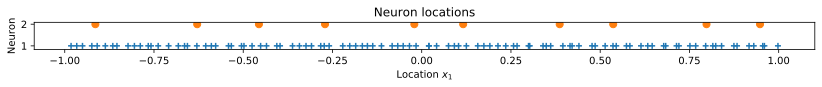

In [16]:
with nengo.Network() as model:
    ens_1 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        locations=bio.NeuralSheetDist(dimensions=1))

    ens_2 = bio.Ensemble(
        n_neurons=10,
        dimensions=1,
        locations=bio.NeuralSheetDist(dimensions=1))

with nengo.Simulator(model, progress_bar=None) as sim:
    pass

fig, ax = plt.subplots(figsize=(14, 0.5))
ax.scatter(sim.data[ens_1].locations[:, 0], np.ones(100), marker='+')
ax.scatter(sim.data[ens_2].locations[:, 0], np.ones(10) * 2, marker='o', sizes=[50])
ax.set_ylabel('Neuron')
ax.set_xlabel('Location $x_1$')
ax.set_title('Neuron locations');

### Constraining connectivity by location

As mentioned above, we can use the `SpatiallyConstrainedConnectivity` class to take the spatial location of individual neurons into account.

Solved 100/100 neuron weights

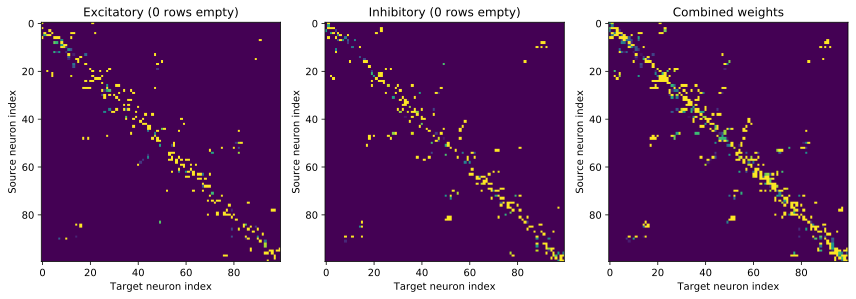

In [17]:
with nengo.Network() as model:
    ens_1 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        locations=bio.NeuralSheetDist())

    ens_2 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        locations=bio.NeuralSheetDist())

    conn = bio.Connection(
        ens_1, ens_2,
        connectivity=bio.SpatiallyConstrainedConnectivity(
            convergence=10,
            sigma=0.25
        ))

with nengo.Simulator(model, progress_bar=None) as sim:
    pass

plot_weights(sim, conn)

As we can see, the connectivity is now concentrated along the digaonal of the connection weight matrix. Note that this pattern is only visible because `NeuralSheetDist` ensures that similar neuron indices are in similar locations.

We can access the underlying probaility distribution that is used to determine connectivity between neural populations by using the `SpatiallyConstrainedConnectivity.get_probabilities` function

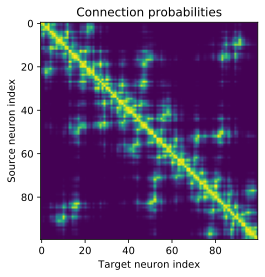

In [18]:
ps = bio.SpatiallyConstrainedConnectivity(
            convergence=10,
            sigma=0.5
        ).get_probabilities(100, 100, ens_1, ens_2, sim.data)

fig, ax = plt.subplots()
ax.imshow(ps)
ax.set_xlabel('Target neuron index')
ax.set_ylabel('Source neuron index')
ax.set_title('Connection probabilities');

### Connectivity constraints for multiple pre-objects

Connectivity constraints apply to each `(pre_obj, post_obj)` pair individually. That is, if a connection projects from two pre-populations onto a single post population with `convergence=10`, each post-neuron will in total receive 20 connections. We can specify constraints for individual connections using the following syntax:

Solved 83/100 neuron weights

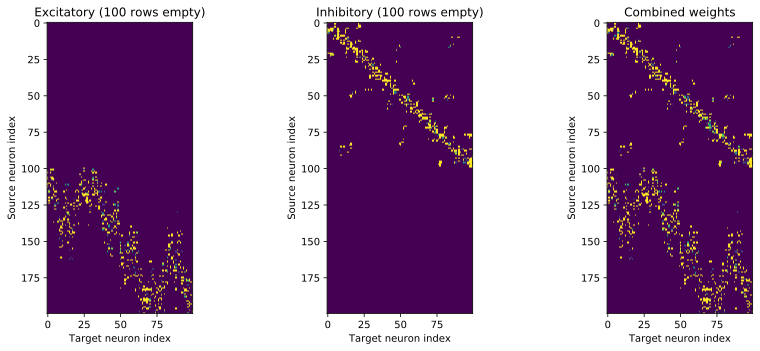

In [19]:
with nengo.Network() as model:
    ens_1 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        p_exc=1.0,
        locations=bio.NeuralSheetDist(dimensions=1))

    ens_2 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        p_inh=1.0,
        locations=bio.NeuralSheetDist(dimensions=2))

    ens_3 = bio.Ensemble(
        n_neurons=100,
        dimensions=1,
        locations=bio.NeuralSheetDist(dimensions=2))

    conn = bio.Connection(
        {ens_1, ens_2}, ens_3,
        connectivity={
            (ens_1, ens_3): bio.SpatiallyConstrainedConnectivity(
                convergence=10,
                sigma=0.25,
                projection=np.array([[1, 0]])
            ),
            (ens_2, ens_3): bio.SpatiallyConstrainedConnectivity(
                convergence=10,
                sigma=0.125,
            ),
        })

with nengo.Simulator(model, progress_bar=None) as sim:
    pass

plot_weights(sim, conn)

Note that in the above example the excitatory ensemble `ens_1` only has one-dimensional locations. In the connectivity constraint specified for the `(ens_1, ens_3)` connection we specify a projetion, that projects the `ens_3` neuron locations onto one dimension, hence allowing us to compute a spatial connectivity constraint for these neurons.